In [1]:
ticker_name = 'FARM'

In [2]:
# !python -m ipykernel install --user --name Py309 --display-name Py309

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from datetime import datetime, timedelta
import itertools
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanSquaredError,  MeanAbsoluteError, RootMeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM, Dropout


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.validation import check_is_fitted
from keras.initializers import glorot_uniform


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
print("Are there GPUs Available: ",tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Device Name: ",tf.test.gpu_device_name())
print("Is built with Cuda: ",tf.test.is_built_with_cuda())
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Are there GPUs Available:  True
Num GPUs Available:  1
GPUs Device Name:  /device:GPU:0
Is built with Cuda:  True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14199953039517835447
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6277824512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15034795015145122987
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
def create_arima_features (ticker_name, year_start= 2000, num_prev_clos = 7, num_int_diff = 3, visualize = False):

    df = pd.read_csv('G:/My Drive/Ingegneria/Data Science GD/stock_market_data/nasdaq/csv/' + ticker_name +'.csv') 
    df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
    df = df[df['Date'].dt.year >= year_start]
    
    # df['CloseID0'] = df['Adjusted Close'].copy()
    
    for days_bef in range(1, num_prev_clos):
        
    #autoregression    
    
        df['CloseAR'+str(days_bef)] = [df['Adjusted Close'].iloc[j - days_bef] 
                                     if j >= days_bef else None
                                     for j in range(len(df))]
   
    #simple moving average  
    
        if days_bef > 1:

            df['CloseSMA'+str(days_bef)] = [np.mean([df['Adjusted Close'].iloc[j - days_bef + i] 
                                                    for i in range(days_bef)])
                                           if j >= days_bef else None
                                           for j in range(len(df))]
            
    #integrated differencing

    for i in range(num_int_diff):
                   df['CloseID'+str(i+2)] = [df['CloseAR'+str(i+1)].iloc[j] - df['CloseAR'+str(i+1)].iloc[j-1]
                     if j > 0 else None
                     for j in range(len(df))]
        
        
    #rolling means of the 'num_prev_close' open, high, low, volume (function that could be used also in the previous formulas)
    
    df['VolumeSMA'+str(num_prev_clos)] = df['Volume'].shift(1).rolling(window=num_prev_clos).mean()
    df['OpenSMA'+str(num_prev_clos)] = df['Open'].shift(1).rolling(window=num_prev_clos).mean()
    df['HighSMA'+str(num_prev_clos)] = df['High'].shift(1).rolling(window=num_prev_clos).mean()
    df['LowSMA'+str(num_prev_clos)] = df['Low'].shift(1).rolling(window=num_prev_clos).mean()
    
    
    #optional visualizations
    
    if visualize:
        plt.plot(df['Date'],df['Adjusted Close'])
        plt.xlabel("Date")
        plt.ylabel("Close")
        plt.title(ticker_name + " Stock Prices")
        
        axes = df[df.sort_index(axis=1).columns].plot(figsize=(10, 40), subplots=True)
        
        plt.show()
    
    df.drop(columns=[ 'Open', 'High', 'Low', 'Close', 'Volume'], inplace = True)
        
    return df.iloc[max(num_prev_clos,num_int_diff):,:] #remove first rows


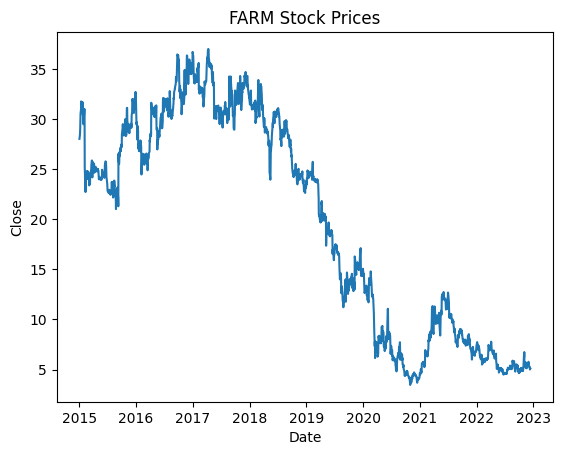

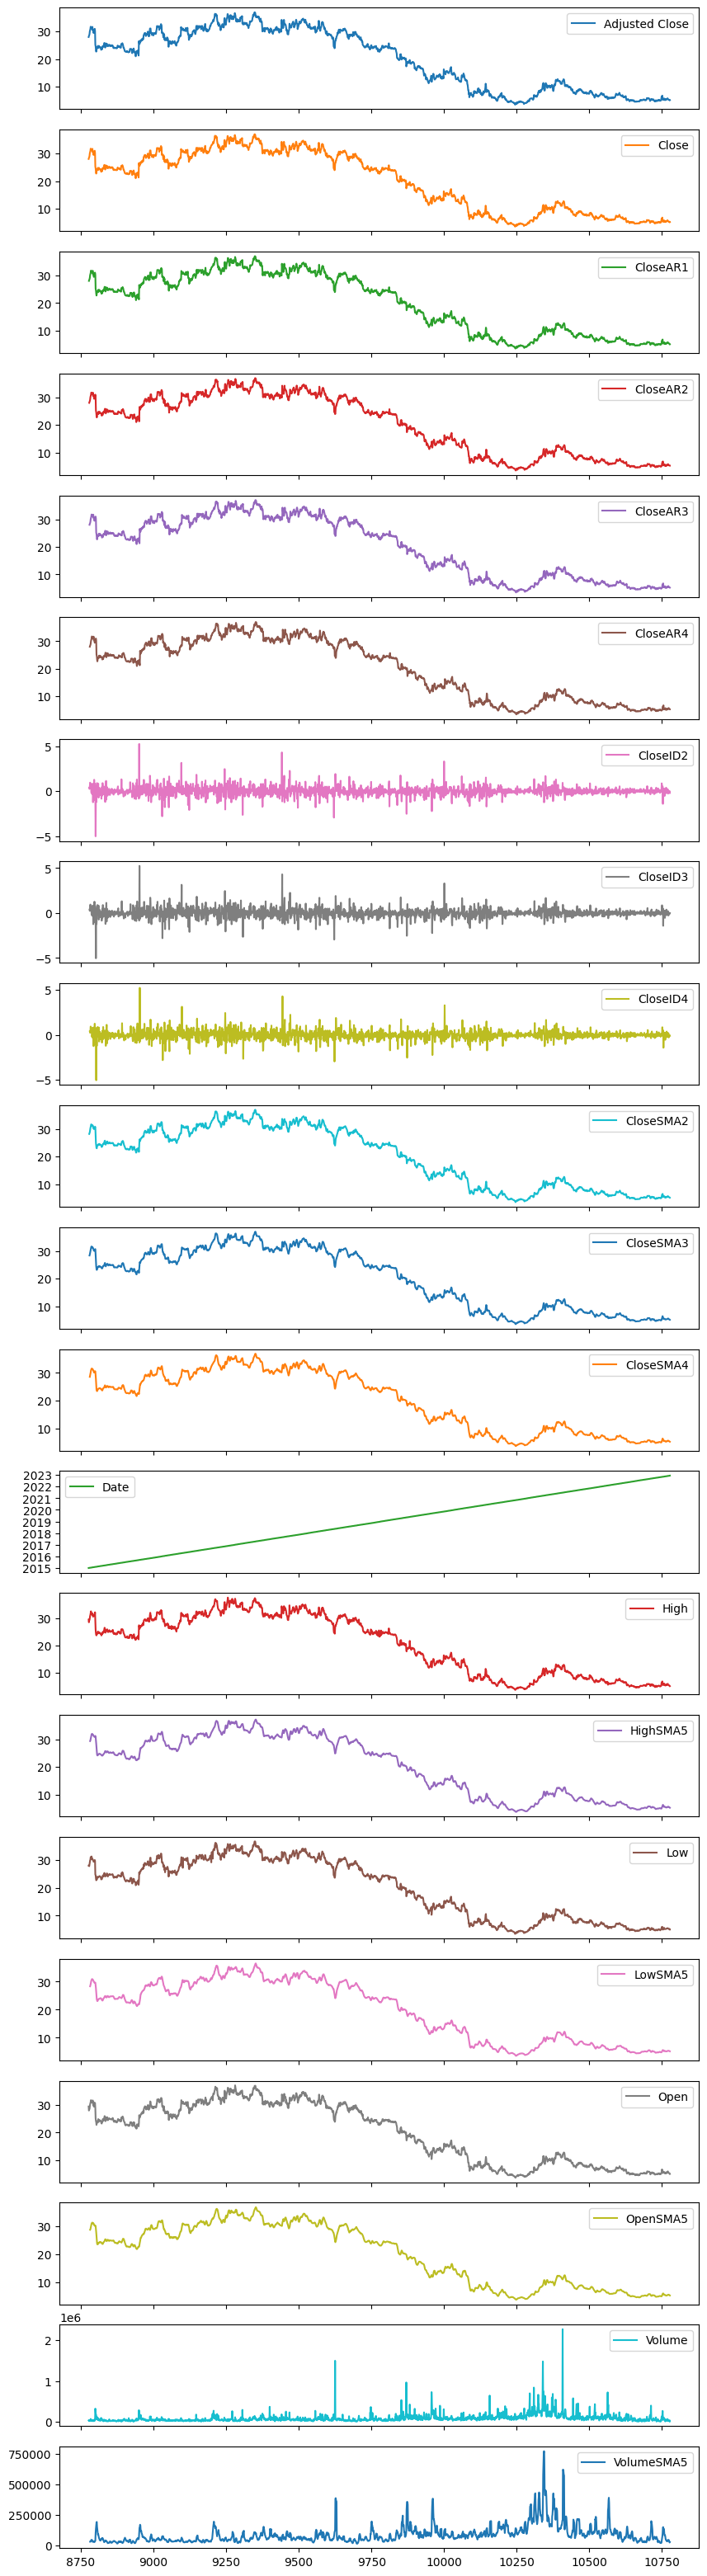

In [5]:
df = create_arima_features(ticker_name = ticker_name, year_start= 2015, visualize = True, num_prev_clos = 5, num_int_diff = 3)

In [6]:
X = df # 'Adjusted Close' and 'date' fields dropped afterwards
y= df['Adjusted Close']

X.head(10)

,Date,Adjusted Close,CloseAR1,CloseAR2,CloseSMA2,CloseAR3,CloseSMA3,CloseAR4,CloseSMA4,CloseID2,CloseID3,CloseID4,VolumeSMA5,OpenSMA5,HighSMA5,LowSMA5
8782,2015-01-09,30.549999,30.059999,29.120001,29.590000,28.650000,29.276667,28.410000,29.0600,0.939999,0.470001,0.240000,29500.0,28.788000,29.336,28.332
8783,2015-01-12,30.950001,30.549999,30.059999,30.304999,29.120001,29.910000,28.650000,29.5950,0.490000,0.939999,0.470001,30120.0,28.940000,29.600,28.704
8784,2015-01-13,31.760000,30.950001,30.549999,30.750000,30.059999,30.520000,29.120001,30.1700,0.400002,0.490000,0.939999,29600.0,29.466000,30.152,29.132
8785,2015-01-14,31.650000,31.760000,30.950001,31.355000,30.549999,31.086667,30.059999,30.8300,0.809999,0.400002,0.490000,37600.0,30.014000,30.698,29.784
8786,2015-01-15,31.420000,31.650000,31.760000,31.705000,30.950001,31.453334,30.549999,31.2275,-0.110001,0.809999,0.400002,43600.0,30.654000,31.326,30.310
8787,2015-01-16,31.500000,31.420000,31.650000,31.535000,31.760000,31.610000,30.950001,31.4450,-0.230000,-0.110001,0.809999,44940.0,30.962000,31.662,30.516
8788,2015-01-20,31.219999,31.500000,31.420000,31.460000,31.650000,31.523333,31.760000,31.5825,0.080000,-0.230000,-0.110001,44460.0,31.191999,31.872,30.804
8789,2015-01-21,30.870001,31.219999,31.500000,31.360000,31.420000,31.380000,31.650000,31.4475,-0.280001,0.080000,-0.230000,41140.0,31.343999,31.952,30.928
8790,2015-01-22,31.700001,30.870001,31.219999,31.045000,31.500000,31.196667,31.420000,31.2525,-0.349998,-0.280001,0.080000,33780.0,31.316000,31.804,30.822
8791,2015-01-23,30.459999,31.700001,30.870001,31.285001,31.219999,31.263334,31.500000,31.3225,0.830000,-0.349998,-0.280001,28500.0,31.136000,31.648,30.694


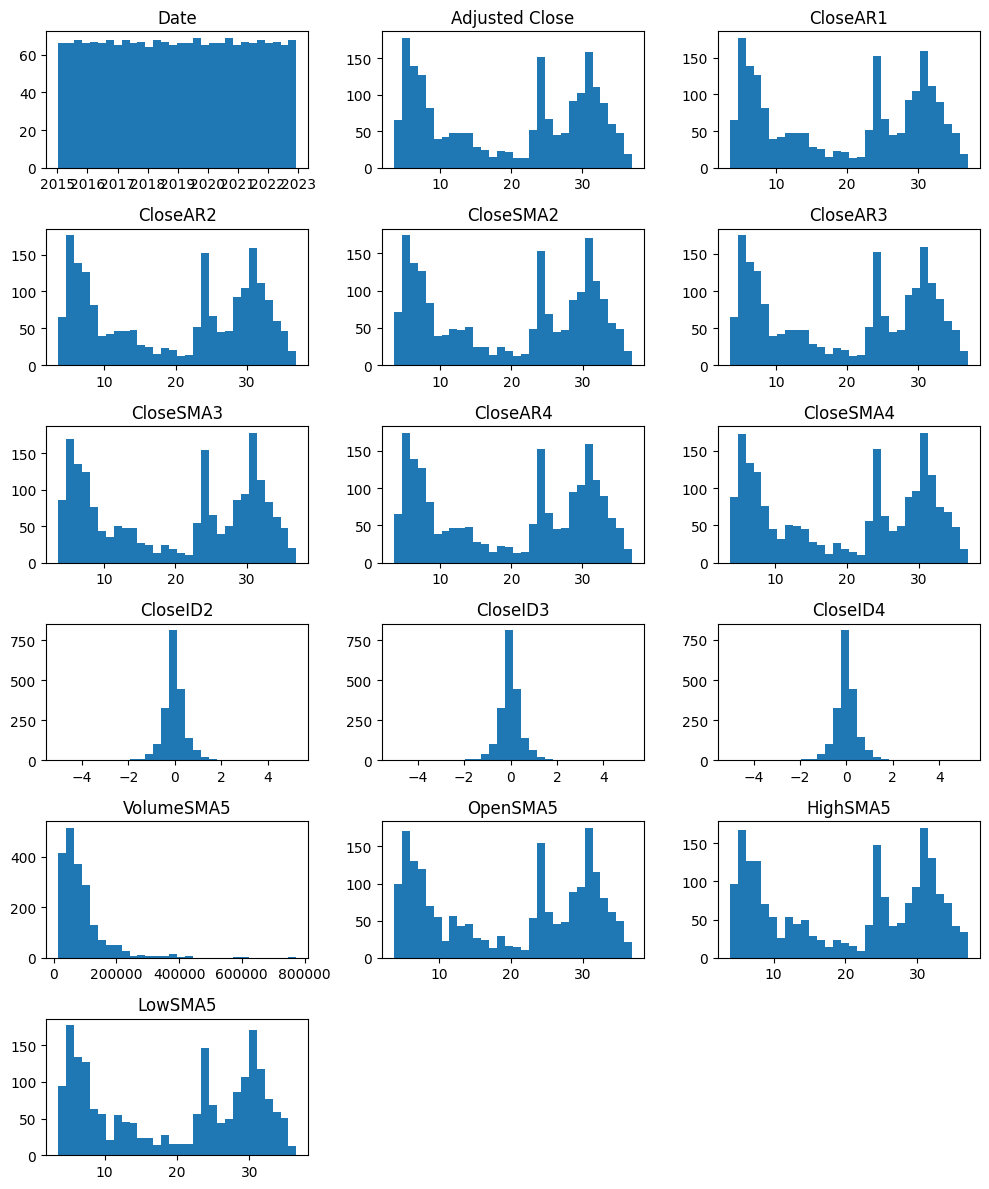

In [7]:
plt.figure(figsize=(10, 12))
for index, feature in enumerate(X, 1):  #starting index from 1, for plotting
    plt.subplot(X.shape[1] // 3 + 1, 3, index)
    plt.hist(X[feature], bins = 30)
    plt.title(feature)
    plt.tight_layout()

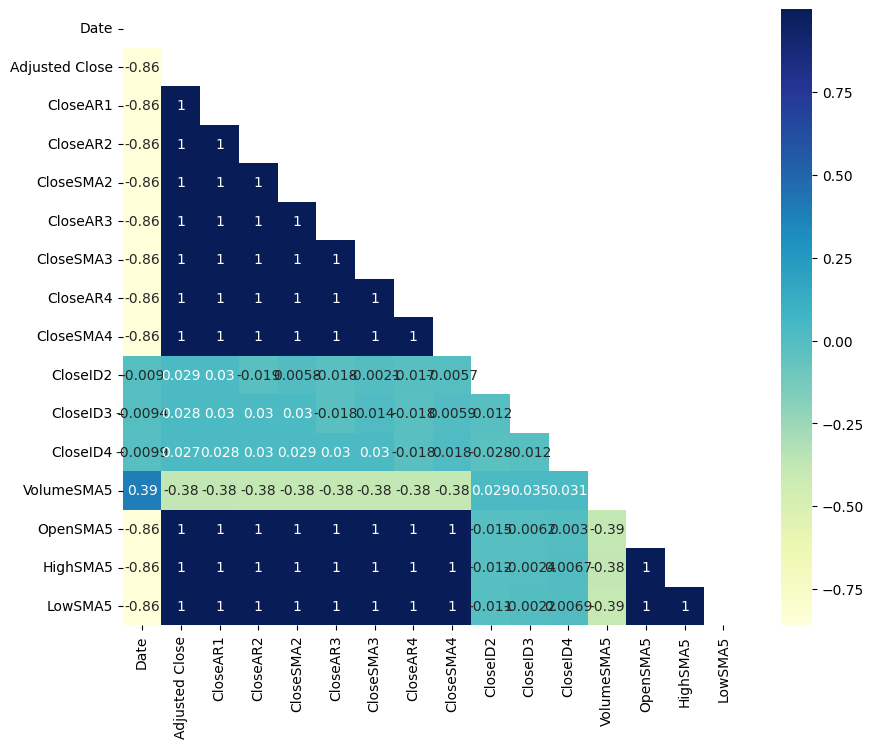

In [8]:
#check features correlation

plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", mask=mask)

# Show the plot
plt.show()

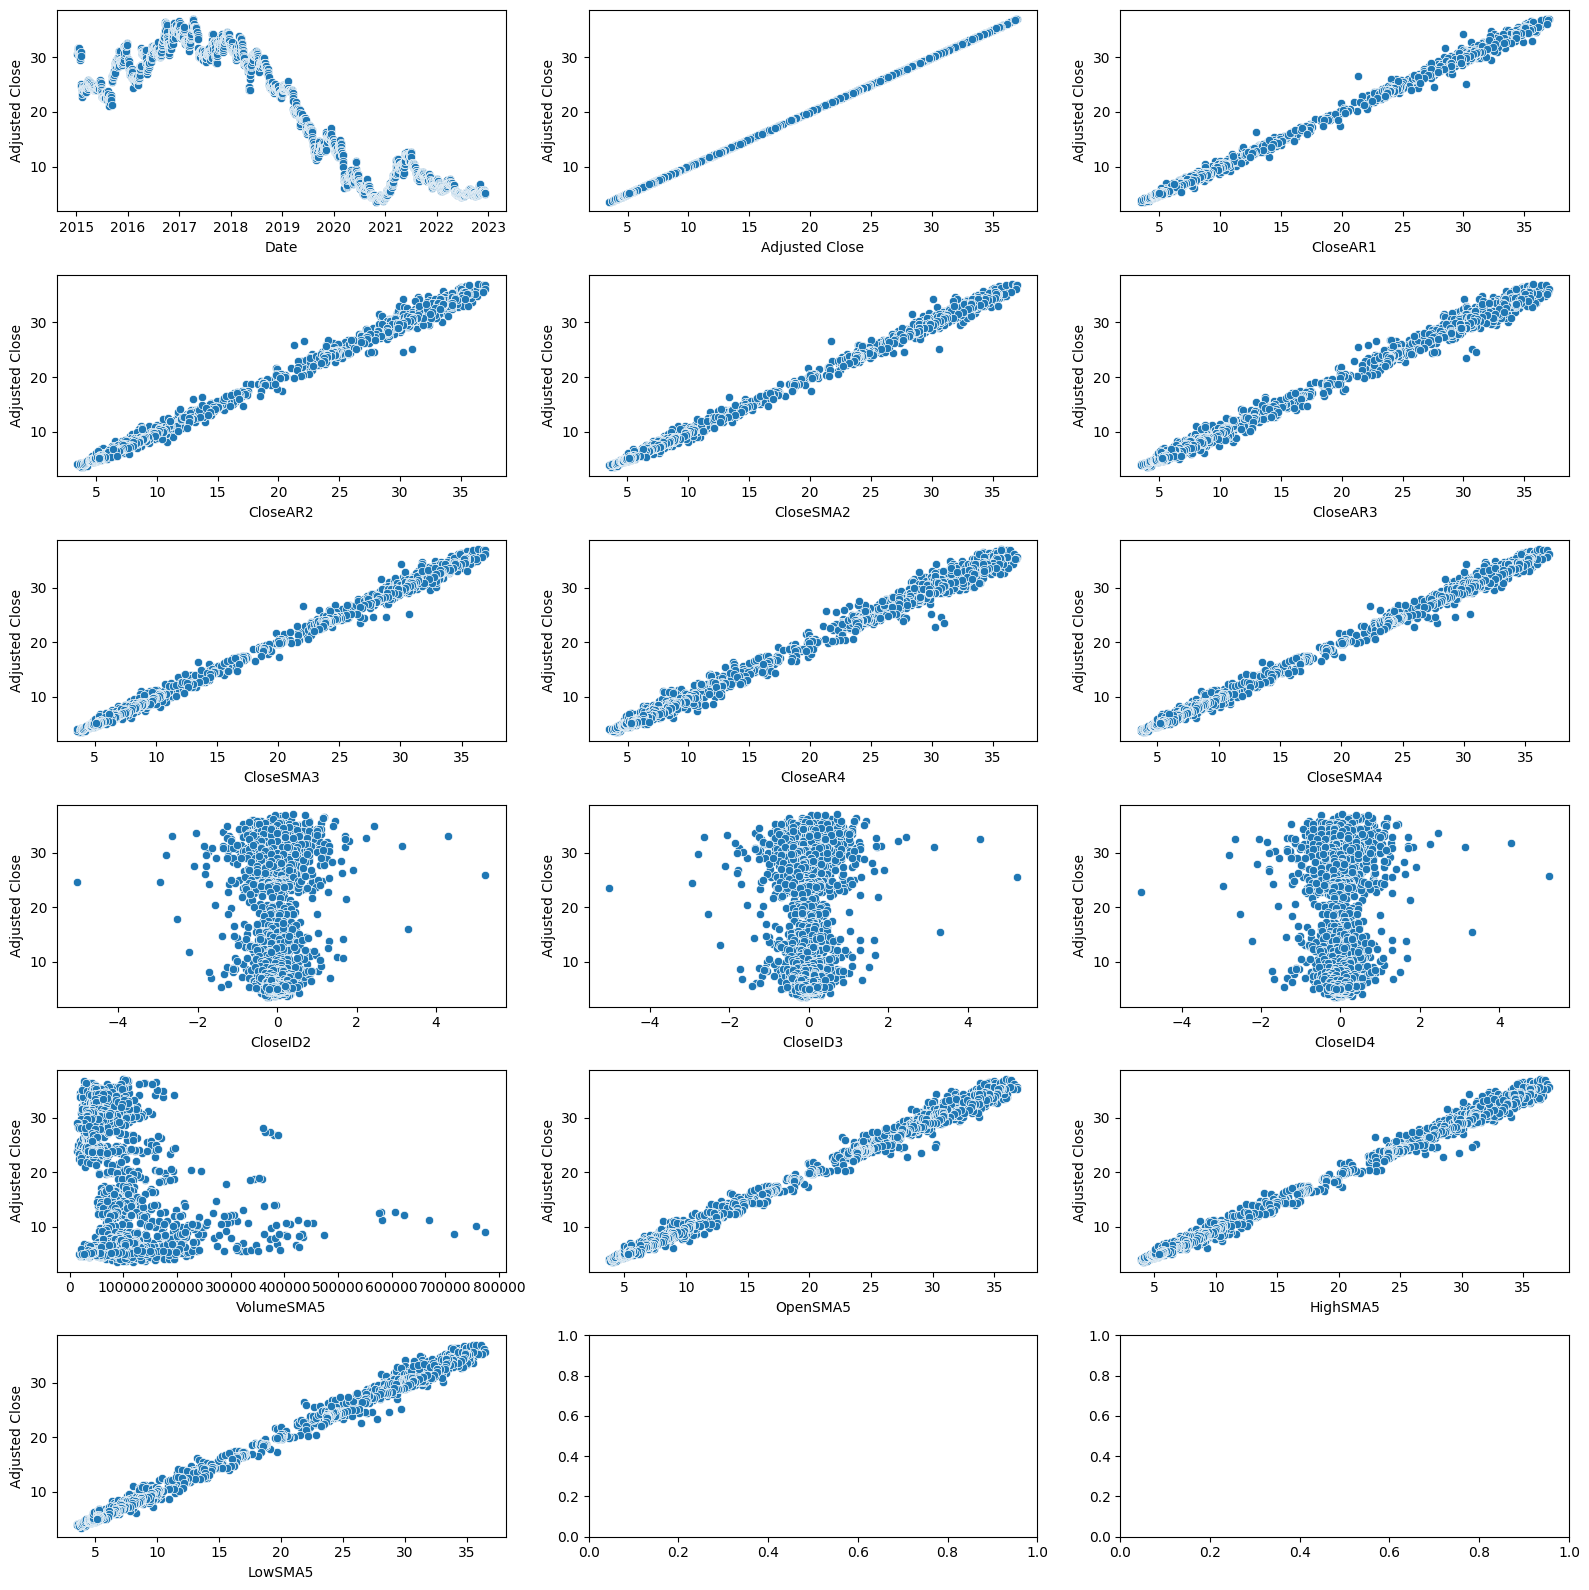

In [9]:
#correlation between features and label

fig, axes = plt.subplots(nrows=X.shape[1] // 3 + 1, ncols=3, figsize=(16, 16))
for i, feature in enumerate(X.columns):
    row = i // 3
    col = i % 3
    sns.scatterplot(x=feature, y='Adjusted Close', data=df, ax=axes[row, col])
plt.tight_layout()
plt.show()


In [10]:
X_Train, X_Test, y_Train, y_Test  = train_test_split(X, y, test_size=0.1, shuffle=False)

In [11]:
# scaler = MinMaxScaler(feature_range=(0, 1))
features_scaler = StandardScaler()
label_scaler = StandardScaler()

X_Train_scaled = features_scaler.fit_transform(X_Train.drop(['Date','Adjusted Close'], axis=1))
X_Test_scaled = features_scaler.transform(X_Test.drop(['Date','Adjusted Close'], axis=1))

y_Train_scaled = label_scaler.fit_transform(y_Train.values.reshape(-1, 1))
y_Test_scaled = label_scaler.transform(y_Test.values.reshape(-1, 1))

In [12]:
X_Train_scaled_resh = X_Train_scaled.reshape((X_Train_scaled.shape[0], 1, X_Train_scaled.shape[1]))
X_Test_scaled_resh = X_Test_scaled.reshape((X_Test_scaled.shape[0], 1, X_Test_scaled.shape[1]))

print(X_Train.shape)
print(X_Train_scaled.shape)
print(X_Train_scaled_resh.shape)

print(X_Test.shape)
print(X_Test_scaled.shape)
print(X_Test_scaled_resh.shape)

(1796, 16)
(1796, 14)
(1796, 1, 14)
(200, 16)
(200, 14)
(200, 1, 14)


*******************************
Fit with y_Train_scaled
******************************

In [13]:
model1 = keras.models.Sequential()
model1.add(keras.layers.Bidirectional(keras.layers.LSTM
                           (units=1024,
                            return_sequences=True, # Whether to return the last output in the output sequence, or the full sequence
                            input_shape=(1, X_Train_scaled.shape[1]), # input_shape = (numb of timesteps: 1, number of features)
                            kernel_initializer=glorot_uniform(),
                            recurrent_initializer=glorot_uniform(),
                            bias_initializer='zeros')))

model1.add(keras.layers.Bidirectional(keras.layers.LSTM(units=512, return_sequences=True)))
model1.add(keras.layers.Dropout(0.01))
model1.add(keras.layers.Bidirectional(keras.layers.LSTM(units=512)))

# flatten the output from the LSTM layer into a 1D vector
#necessary because the output shape of the LSTM layer is (batch_size, timesteps, units), 
#and we want to pass a 2D input of shape (batch_size, n_feat) to the next layer.
model1.add(keras.layers.Flatten()) 

model1.add(keras.layers.Dense(1024))
model1.add(keras.layers.Dropout(0.01))
model1.add(keras.layers.Dense(1))

model1.build((None, 1, X_Train_scaled_resh.shape[2]))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 2048)          8511488   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 1024)          10489856  
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             6295552   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                        

In [14]:
# model2 = tf.keras.Sequential()

# # CNN layers
# model2.add(keras.layers.TimeDistributed(keras.layers.Conv1D(64, kernel_size=3, 
#                                                             activation='relu',  
#                                                             input_shape=(1, X_Train_scaled.shape[1])))) 
#                                                             # input_shape=(None, 100, 1))))
# model2.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2)))
# model2.add(keras.layers.TimeDistributed(keras.layers.Conv1D(128, kernel_size=3, activation='relu')))
# model2.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2)))
# model2.add(keras.layers.TimeDistributed(keras.layers.Conv1D(64, kernel_size=3, activation='relu')))
# model2.add(keras.layers.TimeDistributed(keras.layers.MaxPooling1D(2)))
# model2.add(keras.layers.TimeDistributed(keras.layers.Flatten()))
# # model2.add(Dense(5, kernel_regularizer=L2(0.01)))

# # LSTM layers
# model2.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)))
# model2.add(keras.layers.Dropout(0.5))
# model2.add(keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=False)))
# model2.add(keras.layers.Dropout(0.5))

# #Final layers
# model2.add(keras.layers.Dense(1, activation='linear'))

# model2.build((None, 1, X_Train_scaled_resh.shape[2]))
# model2.summary()

# # model2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# # history = model2.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

In [15]:
model = model1

early_stopping_monitor = EarlyStopping(monitor='loss', patience=15)

optimizer = Adam(lr=0.0007)

model.compile(optimizer=optimizer,
               # metrics=[MeanSquaredError(), MeanAbsoluteError(), RootMeanSquaredError()],
               metrics=['mse', 'mae'],
               # loss='mean_squared_error'
               loss='mse')
history = model.fit(X_Train_scaled_resh,
                    y_Train_scaled,
                    epochs=100,
                    # batch_size=40,
                    validation_data=(X_Test_scaled_resh,y_Test_scaled),
                    callbacks=[early_stopping_monitor])

Epoch 1/100
57/57 [==============================] - 12s 60ms/step - loss: 0.0733 - mse: 0.0733 - mae: 0.1599 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0799
Epoch 2/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0449 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0626
Epoch 3/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0454 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0613
Epoch 4/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0460 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.1185
Epoch 5/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0492 - val_loss: 0.0041 - val_mse: 0.0041 - val_mae: 0.0604
Epoch 6/100
57/57 [==============================] - 1s 19ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0520 - val_loss: 7.4125e-04 - val_mse: 7.4125e-04 - val_mae: 0.0209
Epoch 7

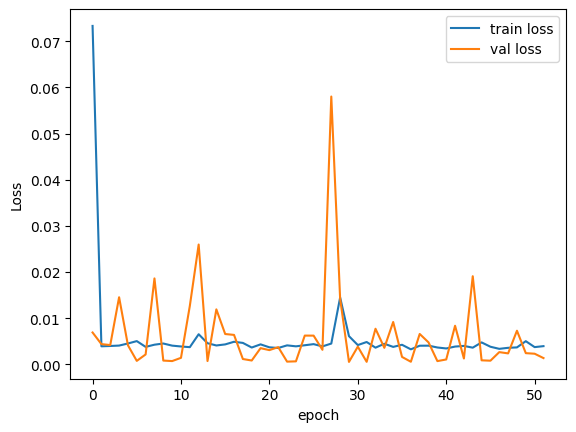

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

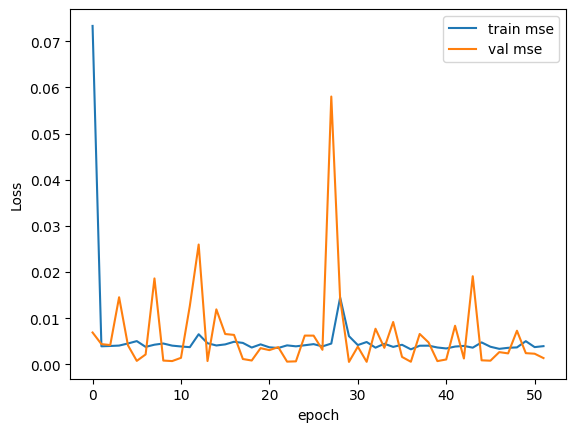

In [17]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

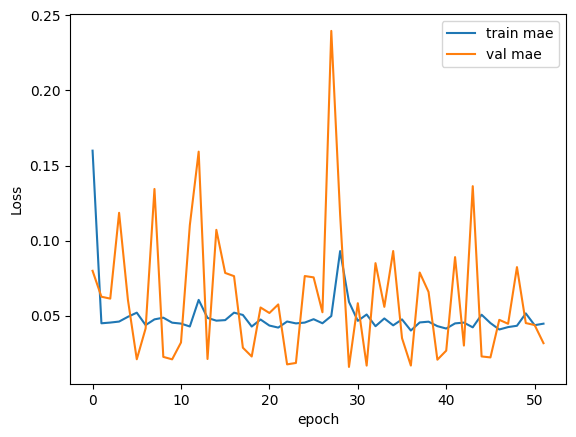

In [18]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [19]:
# predict the testing data
y_Pred = model1.predict(X_Test_scaled_resh)
y_Pred_invers = label_scaler.inverse_transform(y_Pred)
y_Pred_invers_arr = np.array(list(itertools.chain(*y_Pred_invers)))

# Reshape y_Test to 1D array
y_Test_arr = y_Test.values 
 
# evaluation metrics
mse = np.mean(((y_Pred_invers_arr - y_Test_arr) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

for i in range (7):
    print(i)
    print('y_Pred:', y_Pred_invers_arr[i])
    print('y_Test:', y_Test_arr[i])
    print('diff:', y_Pred_invers_arr[i] - y_Test_arr[i])

7/7 [==============================] - 2s 10ms/step
MSE 0.14099001481079426
RMSE 0.37548637100538584
0
y_Pred: 6.3693223
y_Test: 6.119999885559082
diff: 0.24932241439819336
1
y_Pred: 6.3235106
y_Test: 5.940000057220459
diff: 0.3835105895996094
2
y_Pred: 6.132629
y_Test: 6.070000171661377
diff: 0.06262874603271484
3
y_Pred: 6.3408494
y_Test: 6.010000228881836
diff: 0.33084917068481445
4
y_Pred: 6.2680774
y_Test: 5.940000057220459
diff: 0.3280773162841797
5
y_Pred: 6.1940017
y_Test: 6.050000190734863
diff: 0.14400148391723633
6
y_Pred: 6.3410783
y_Test: 5.960000038146973
diff: 0.38107824325561523


In [20]:
# def r2_score(y_true, y_pred):
#     SS_res = K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return 1 - SS_res / (SS_tot + K.epsilon())

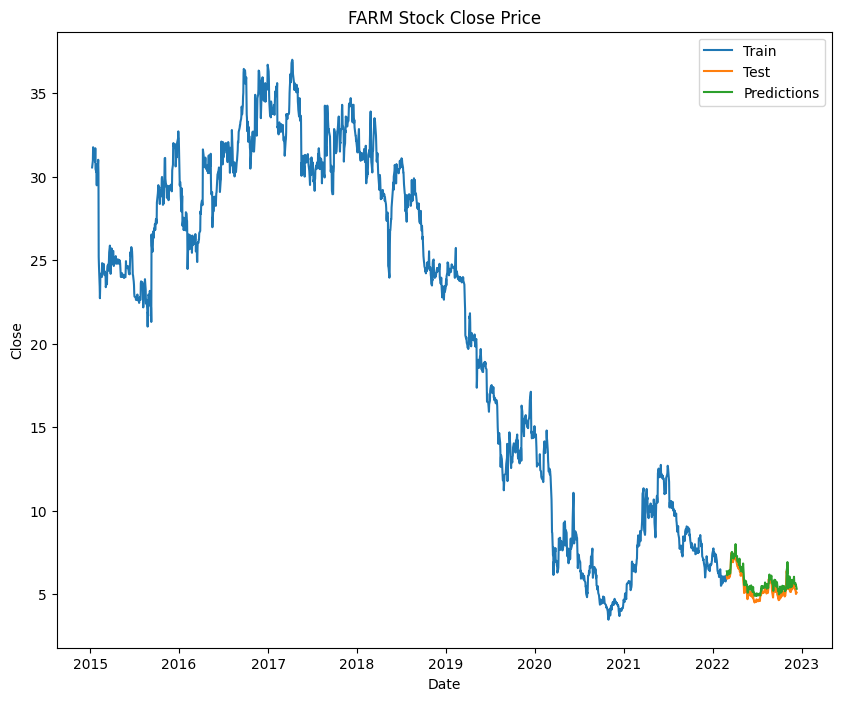

In [21]:
df_viz_test = X_Test[['Date','Adjusted Close']].assign(Predicted_Close = y_Pred_invers_arr).rename(columns={'Adjusted Close': 'Actual_Close'})
df_viz_train = X_Train[['Date','Adjusted Close']].rename(columns={'Adjusted Close': 'Actual_Close'})

plt.figure(figsize=(10, 8))
plt.plot(df_viz_train['Date'], df_viz_train['Actual_Close'])
plt.plot(df_viz_test['Date'], df_viz_test[['Actual_Close', 'Predicted_Close']])
plt.title(ticker_name+' Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train', 'Test', 'Predictions'])

In [22]:
pd.set_option('display.max_rows', None)

df_viz_train['Predicted_Close'] = None
last_row_df_Train = pd.DataFrame(df_viz_train.iloc[-1]).transpose()
df_predictions = pd.concat([last_row_df_Train, df_viz_test], axis=0).reset_index()
df_predictions['Previous_Close'] = df_predictions['Actual_Close'].shift(1)
df_predictions = df_predictions[1::]
df_predictions['Pred_Increased'] = df_predictions.apply(lambda x: 1 if x['Predicted_Close'] > x['Previous_Close'] else 0, axis=1)
df_predictions['Act_Increased'] = df_predictions.apply(lambda x: 1 if x['Actual_Close'] > x['Previous_Close'] else 0, axis=1)
df_predictions['Pred_variat_perc'] = (df_predictions['Predicted_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions['Act_variat_perc'] = (df_predictions['Actual_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions['Act_variat_perc'] = (df_predictions['Actual_Close'] - df_predictions['Previous_Close'])/df_predictions['Previous_Close']*100
df_predictions.head()



,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc
1,10578,2022-02-28,6.12,6.369322,6.09,1,1,4.58657,0.492606
2,10579,2022-03-01,5.94,6.323511,6.12,1,0,3.325339,-2.941174
3,10580,2022-03-02,6.07,6.132629,5.94,1,1,3.24291,2.188554
4,10581,2022-03-03,6.01,6.340849,6.07,1,0,4.462096,-0.988467
5,10582,2022-03-04,5.94,6.268077,6.01,1,0,4.294129,-1.164728


Text(0.5, 1.0, 'Confusion Matrix')

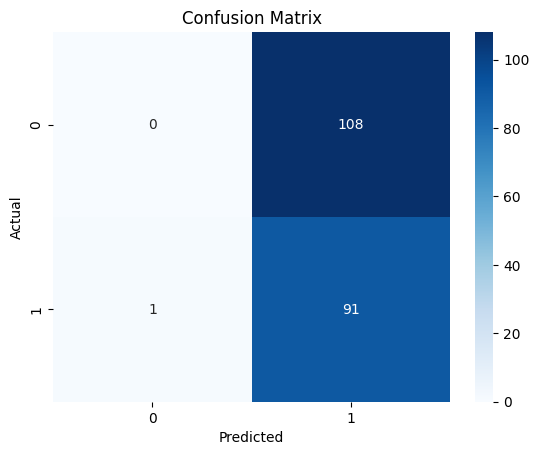

In [23]:
# Create confusion matrix
cm = confusion_matrix(df_predictions['Act_Increased'], df_predictions['Pred_Increased'])

# Visualize confusion matrix as heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [24]:
report = classification_report(df_predictions['Act_Increased'], df_predictions['Pred_Increased'])

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.46      0.99      0.63        92

    accuracy                           0.46       200
   macro avg       0.23      0.49      0.31       200
weighted avg       0.21      0.46      0.29       200



In [25]:

def Calc_Return(init_invest, max_desired_invest = np.inf,  risk_factor = 1, commiss_perc = 0.01):
    
    Day_Amount_Invest = []
    Day_Amount_Return = []    
    Day_Short_Commiss = []
    Day_End_Amount = []
        
    for i in range(len(df_predictions)):
        
        # percentage invested proportional to the confidence of the model prediction
        perc_invest = df_predictions['Pred_variat_perc'].iloc[i] 
        #percentage of gain or loss 
        perc_gain_loss = df_predictions['Act_variat_perc'].iloc[i] 
        
        prev_amount_owned = init_invest if i == 0 else Day_End_Amount[i - 1]

        max_amount_invest = min(max_desired_invest, prev_amount_owned)
        
        amount_invest = min(prev_amount_owned * np.abs(perc_invest)/100 * risk_factor, max_amount_invest)
        # could be eventually modified, if we want to allow to invest more than the amount owned, during short trading
        Day_Amount_Invest.append(amount_invest)
        
        if commiss_perc <= 0: # no short positions allowed
            daily_return = amount_invest * perc_gain_loss/100 if np.sign(perc_invest) == 1 else 0
        else: #short positions allowed
            daily_return = amount_invest * np.abs(perc_gain_loss)/100 * np.sign(perc_invest) * np.sign(perc_gain_loss)
            # positive if sign(perc_invest)==sign(perc_gain_loss), negative otherwise
        
        Day_Amount_Return.append(daily_return)
        
        short_commiss = amount_invest * commiss_perc if np.sign(perc_invest) == -1 else 0
        Day_Short_Commiss.append(short_commiss)
        
        Day_End_Amount.append(prev_amount_owned + daily_return - short_commiss)

    return Day_Amount_Invest, Day_Short_Commiss, Day_Amount_Return, Day_End_Amount



In [33]:
Day_Amount_Invest, Day_Short_Commiss, Day_Amount_Return, Day_End_Amount = \
Calc_Return(init_invest = 10000, risk_factor = 10, commiss_perc = 0.001)

df_predictions['Day_Amount_Invest'] = Day_Amount_Invest
df_predictions['Day_Short_Commiss'] = Day_Short_Commiss
df_predictions['Day_Amount_Return'] = Day_Amount_Return
df_predictions['Day_End_Amount'] = Day_End_Amount
df_predictions

,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc,Day_Amount_Invest,Day_Short_Commiss,Day_Amount_Return,Day_End_Amount
1,10578,2022-02-28,6.12,6.369322,6.09,1,1,4.58657,0.492606,4586.570449,0.000000,22.593741,10022.593741
2,10579,2022-03-01,5.94,6.323511,6.12,1,0,3.325339,-2.941174,3332.852484,0.000000,-98.024981,9924.568760
3,10580,2022-03-02,6.07,6.132629,5.94,1,1,3.24291,2.188554,3218.448405,0.000000,70.437484,9995.006244
4,10581,2022-03-03,6.01,6.340849,6.07,1,0,4.462096,-0.988467,4459.867624,0.000000,-44.084315,9950.921929
5,10582,2022-03-04,5.94,6.268077,6.01,1,0,4.294129,-1.164728,4273.053943,0.000000,-49.769467,9901.152462
6,10583,2022-03-07,6.05,6.194002,5.94,1,1,4.276121,1.851854,4233.853056,0.000000,78.404781,9979.557242
7,10584,2022-03-08,5.96,6.341078,6.05,1,0,4.811208,-1.487606,4801.372523,0.000000,-71.425495,9908.131747
8,10585,2022-03-09,6.13,6.225188,5.96,1,1,4.449459,2.85235,4408.582302,0.000000,125.748209,10033.879956
9,10586,2022-03-10,6.15,6.428475,6.13,1,1,4.869083,0.326264,4885.579353,0.000000,15.939885,10049.819840
10,10587,2022-03-11,6.01,6.406363,6.15,1,0,4.168503,-2.276421,4189.270032,0.000000,-95.365404,9954.454436


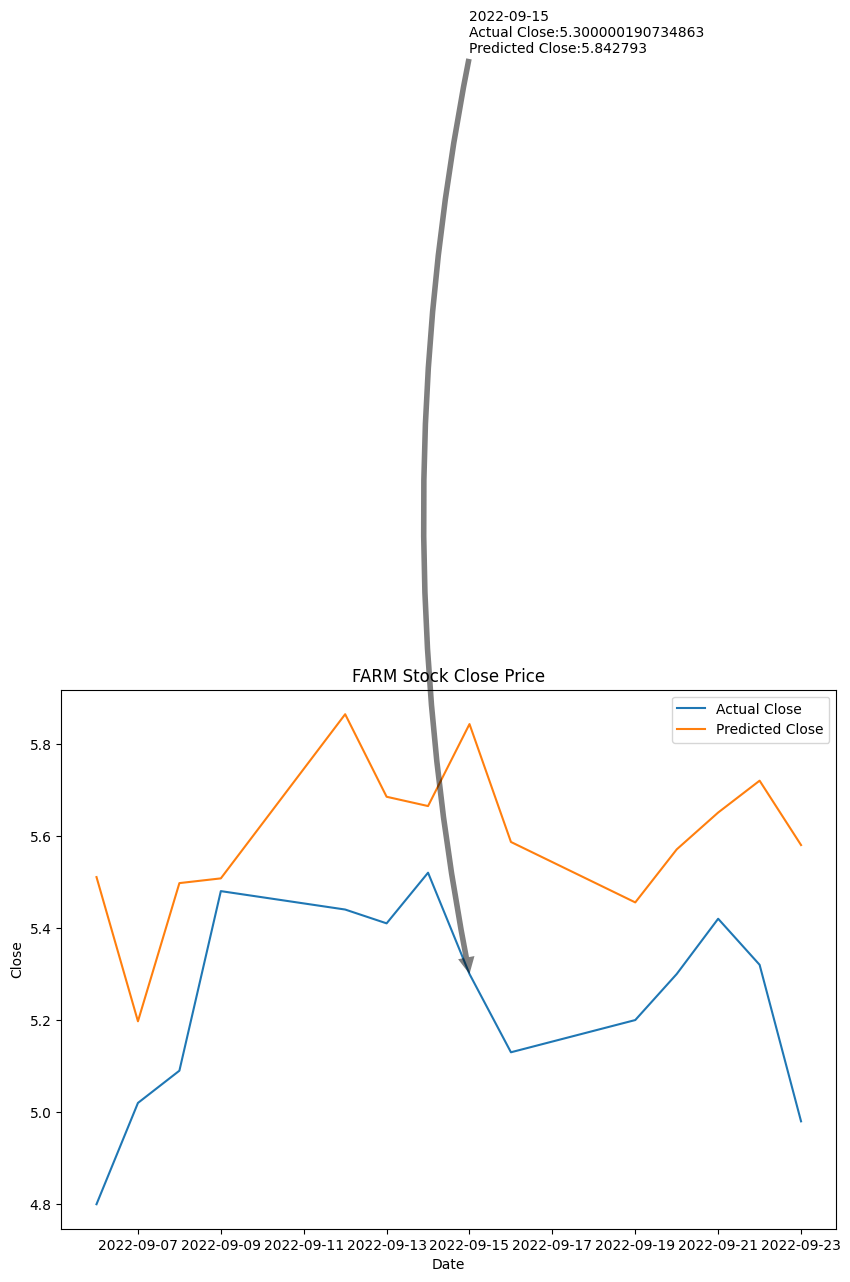

In [27]:
date_to_annotate = datetime(2022, 9, 15)
time_window = 10

start_date = date_to_annotate - timedelta(days=time_window)
end_date = date_to_annotate + timedelta(days=time_window)

df_pred_filt = df_predictions[(df_predictions['Date'] >= start_date) & (df_predictions['Date'] <= end_date)]

plt.figure(figsize=(10, 7))

# Filter the DataFrame based on the date range
plt.plot(df_pred_filt['Date'], 
         df_pred_filt[['Actual_Close', 'Predicted_Close']])
plt.title(ticker_name + ' Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Actual Close', 'Predicted Close'])

# Find the index of the date to annotate
date_index = df_predictions[df_predictions['Date'] == date_to_annotate].index[0]
act_close = df_predictions[df_predictions['Date'] == date_to_annotate]['Actual_Close']
pred_close = df_predictions[df_predictions['Date'] == date_to_annotate]['Predicted_Close']

# Annotate the date
plt.annotate(str(date_to_annotate.date())+'\nActual Close:'+str(act_close.values[0])+'\nPredicted Close:'+str(pred_close.values[0]), 
             xy=(date_to_annotate, df_predictions['Actual_Close'][date_index]), 
             xytext=(date_to_annotate, df_predictions['Actual_Close'][date_index] + 2),
             arrowprops=dict(facecolor='black', linewidth=0.001, alpha = 0.5, connectionstyle="arc3,rad=0.1"))

plt.tight_layout()
plt.show()


In [28]:
df_pred_filt

,index,Date,Actual_Close,Predicted_Close,Previous_Close,Pred_Increased,Act_Increased,Pred_variat_perc,Act_variat_perc,Day_Amount_Invest,Day_Short_Commiss,Day_Amount_Return,Day_End_Amount
132,10709,2022-09-06,4.8,5.510507,5.16,1,0,6.792777,-6.976738,7085.252580,0.0,-494.319491,9936.249707
133,10710,2022-09-07,5.02,5.197284,4.8,1,1,8.27675,4.583329,8223.985789,0.0,376.932308,10313.182014
134,10711,2022-09-08,5.09,5.497397,5.02,1,1,9.5099,1.394426,9807.732694,0.0,136.761549,10449.943563
135,10712,2022-09-09,5.48,5.507671,5.09,1,1,8.205711,7.66208,8574.922185,0.0,657.017369,11106.960932
136,10713,2022-09-12,5.44,5.864191,5.48,1,0,7.010777,-0.729926,7786.842187,0.0,-56.838210,11050.122722
137,10714,2022-09-13,5.41,5.684931,5.44,1,0,4.502412,-0.551474,4975.220629,0.0,-27.437070,11022.685652
138,10715,2022-09-14,5.52,5.664730,5.41,1,1,4.708498,2.033274,5190.029603,0.0,105.527535,11128.213187
139,10716,2022-09-15,5.3,5.842793,5.52,1,0,5.847699,-3.985503,6507.444581,0.0,-259.354429,10868.858758
140,10717,2022-09-16,5.13,5.586759,5.3,1,0,5.410545,-3.207548,5880.645031,0.0,-188.624541,10680.234217
141,10718,2022-09-19,5.2,5.455489,5.13,1,1,6.344806,1.364516,6776.401670,0.0,92.465115,10772.699332


In [29]:
X_Test[(X_Test.Date >= start_date) & (X_Test.Date <= end_date)]

,Date,Adjusted Close,CloseAR1,CloseAR2,CloseSMA2,CloseAR3,CloseSMA3,CloseAR4,CloseSMA4,CloseID2,CloseID3,CloseID4,VolumeSMA5,OpenSMA5,HighSMA5,LowSMA5
10709,2022-09-06,4.80,5.16,5.39,5.275,5.61,5.386667,5.73,5.4725,-0.23,-0.22,-0.12,64540.0,5.708,5.806,5.366
10710,2022-09-07,5.02,4.80,5.16,4.980,5.39,5.116667,5.61,5.2400,-0.36,-0.23,-0.22,71900.0,5.588,5.708,5.200
10711,2022-09-08,5.09,5.02,4.80,4.910,5.16,4.993333,5.39,5.0925,0.22,-0.36,-0.23,100860.0,5.384,5.542,5.052
10712,2022-09-09,5.48,5.09,5.02,5.055,4.80,4.970000,5.16,5.0175,0.07,0.22,-0.36,130040.0,5.226,5.424,4.944
10713,2022-09-12,5.44,5.48,5.09,5.285,5.02,5.196667,4.80,5.0975,0.39,0.07,0.22,198380.0,5.126,5.392,4.914
10714,2022-09-13,5.41,5.44,5.48,5.460,5.09,5.336667,5.02,5.2575,-0.04,0.39,0.07,182780.0,5.110,5.398,4.976
10715,2022-09-14,5.52,5.41,5.44,5.425,5.48,5.443333,5.09,5.3550,-0.03,-0.04,0.39,173380.0,5.142,5.450,5.100
10716,2022-09-15,5.30,5.52,5.41,5.465,5.44,5.456667,5.48,5.4625,0.11,-0.03,-0.04,150860.0,5.286,5.588,5.244
10717,2022-09-16,5.13,5.30,5.52,5.410,5.41,5.410000,5.44,5.4175,-0.22,0.11,-0.03,124560.0,5.392,5.676,5.294
10718,2022-09-19,5.20,5.13,5.30,5.215,5.52,5.316667,5.41,5.3400,-0.17,-0.22,0.11,57060.0,5.400,5.672,5.290
